# Single Elders Home Monitoring : PCA filtering

In [1]:
# selecting framework for data management:
PANDAS = False
SPARK = True

import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.ndimage import median_filter
import plotly
import plotly.express as px
import plotly.offline as py
import sklearn

# import custom classes/libs
from PCAWrapper import PCAWrapper

# Enable offline mode
import plotly.io as pio
pio.renderers.keys()
pio.renderers.default = 'jupyterlab' 


# spark
if SPARK:
    from pyspark.conf import SparkConf
    from pyspark.sql import SparkSession 
    '''
    spark = (SparkSession.
         builder.
         master('local[*]'). # leave out for cluster mode
         appName('single-elders-monitoring').
         config(conf = SparkConf()).
         getOrCreate())
    '''

    from pyspark.sql.functions import col
    from pyspark.sql.window import Window
    from pyspark.sql import functions as F
    from pyspark.sql.types import FloatType
    from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
    from pyspark.ml.functions import vector_to_array
    from pyspark.ml.feature import StandardScaler
    from pyspark.sql.functions import col, concat, dayofmonth, hour, month, year
    from pyspark.sql.functions import mean
    from pyspark.sql.functions import lit


### Import datasets

In [2]:
no_occupants_url = './data/data_ref_until_2020-02-13.csv'

if PANDAS:
    no_occupants_df = pd.read_csv(no_occupants_url)
    print(no_occupants_df)
    print('The dataset with no occupants has {} rows and {} features.'.format(*no_occupants_df.shape))
if SPARK:
    no_occupants_df = spark.read.csv(no_occupants_url, header=True,inferSchema=True)
    no_occupants_df.show()
    print('The dataset with no occupants has {} rows and {} features.'.format(no_occupants_df.count(), len(no_occupants_df.columns)))

+--------------------+-----------+--------+-------------+-------------+-----+-----+-----+-----+-------+
|           timestamp|temperature|humidity|CO2CosIRValue|CO2MG811Value| MOX1| MOX2| MOX3| MOX4|COValue|
+--------------------+-----------+--------+-------------+-------------+-----+-----+-----+-----+-------+
|2020-01-24 23:01:...|      20.64|   55.57|        121.0|        496.0|521.0|694.0|652.0|591.0|  135.0|
|2020-01-24 23:02:...|      20.64|   55.53|        122.0|        495.0|521.0|694.0|652.0|591.0|  135.0|
|2020-01-24 23:02:...|      20.62|   55.53|        121.0|        495.0|522.0|694.0|651.0|591.0|  135.0|
|2020-01-24 23:02:...|      20.62|   55.57|        121.0|        495.0|522.0|694.0|651.0|591.0|  135.0|
|2020-01-24 23:03:...|      20.62|   55.59|        121.0|        495.0|522.0|694.0|652.0|591.0|  135.0|
|2020-01-24 23:03:...|      20.62|   55.71|        121.0|        495.0|522.0|694.0|652.0|591.0|  134.0|
|2020-01-24 23:03:...|      20.62|   55.74|        121.0|       

In [3]:
occupants_url = './data/database_gas.csv'

if PANDAS:
    occupants_df = pd.read_csv(occupants_url)
    print(occupants_df)
    print('The dataset with occupants has {} rows and {} features.'.format(*occupants_df.shape))
          
if SPARK:
    occupants_df = spark.read.csv(occupants_url, header=True,inferSchema=True)
    occupants_df.show()
    print('The dataset with occupants has {} rows and {} features.'.format(occupants_df.count(), len(occupants_df.columns)))

+--------------------+-----------+--------+-------------+-------------+-----+-----+-----+-----+-------+
|           timestamp|temperature|humidity|CO2CosIRValue|CO2MG811Value| MOX1| MOX2| MOX3| MOX4|COValue|
+--------------------+-----------+--------+-------------+-------------+-----+-----+-----+-----+-------+
|2019-11-06 10:37:...|      19.48|   54.86|        128.0|        563.0|476.0|731.0|649.0|565.0|  128.0|
|2019-11-06 10:37:...|      19.59|   54.23|        129.0|        563.0|477.0|731.0|649.0|565.0|  125.0|
|2019-11-06 10:37:...|      19.63|   54.05|        128.0|        566.0|478.0|732.0|649.0|565.0|  125.0|
|2019-11-06 10:38:...|      19.64|   53.74|        128.0|        566.0|478.0|732.0|649.0|565.0|  125.0|
|2019-11-06 10:38:...|      19.67|   53.53|        128.0|        569.0|480.0|732.0|650.0|565.0|  125.0|
|2019-11-06 10:38:...|      19.67|   53.53|        126.0|        570.0|481.0|733.0|650.0|565.0|  123.0|
|2019-11-06 10:39:...|      19.67|   53.53|        128.0|       

## Sliding window median filter

In [4]:
window_size=11

if PANDAS:
    # filtering dataset of when no occupant is in the house
    no_occupants_filtered_df = no_occupants_df.drop(columns=['timestamp']).rolling(window=window_size, 
                                                                                   min_periods=window_size//2 + 1,
                                                                                   center=True).median()
    no_occupants_filtered_df['timestamp'] = no_occupants_df['timestamp']
    no_occupants_filtered_df = no_occupants_filtered_df.reset_index(drop=True)
    print('The filtered dataset with no occupants has {} rows and {} features.'.format(*no_occupants_filtered_df.shape))

    # filtering dataset with occupant in the house
    occupants_filtered_df = occupants_df.drop(columns=['timestamp']).rolling(window=window_size, 
                                                                                   min_periods=window_size//2 + 1,
                                                                                   center=True).median()
    occupants_filtered_df['timestamp'] = occupants_df['timestamp']
    occupants_filtered_df.dropna(inplace=True)
    occupants_filtered_df.reset_index(inplace=True, drop=True)
    print(occupants_filtered_df)
    print('The filtered dataset with occupants has {} rows and {} features.'.format(*occupants_filtered_df.shape))

if SPARK:
    # defining window
    windowSpec = Window.orderBy("timestamp").partitionBy("day_month_year").rowsBetween(-window_size//2, window_size//2) #Note: we can divide partition by hours to speed up computation

    # Spark doesn't have a built-in implementation of median
    rolling_median_udf = F.udf(lambda x: float(np.median(x)), FloatType())

    cols_to_process = no_occupants_df.columns.copy()
    cols_to_process.remove('timestamp')

    conversion_dict = {column: rolling_median_udf(F.collect_list(column).over(windowSpec)) for column in cols_to_process}
    
    # filtering dataset of when no occupant is in the house
    no_occupants_filtered_df = no_occupants_df.withColumn("day_month_year", concat(dayofmonth(col("timestamp")), month(col("timestamp")), year(col("timestamp"))))
    no_occupants_filtered_df = no_occupants_filtered_df.withColumns(conversion_dict)
    no_occupants_filtered_df.sort('timestamp').show()
    print('The filtered dataset with no occupants has {} rows and {} features.'.format(no_occupants_filtered_df.count(), len(no_occupants_filtered_df.columns)))

    # filtering dataset of when occupant is in the house
    occupants_filtered_df = occupants_df.withColumn("day_month_year", concat(dayofmonth(col("timestamp")), month(col("timestamp")), year(col("timestamp"))))
    occupants_filtered_df = occupants_filtered_df.withColumns(conversion_dict)
    occupants_filtered_df.sort('timestamp').show()
    print('The filtered dataset with occupants has {} rows and {} features.'.format(occupants_filtered_df.count(), len(occupants_filtered_df.columns)))
    

+--------------------+-----------+--------+-------------+-------------+-----+-----+-----+-----+-------+--------------+
|           timestamp|temperature|humidity|CO2CosIRValue|CO2MG811Value| MOX1| MOX2| MOX3| MOX4|COValue|day_month_year|
+--------------------+-----------+--------+-------------+-------------+-----+-----+-----+-----+-------+--------------+
|2020-01-24 23:01:...|      20.62|   55.57|        121.0|        495.0|522.0|694.0|652.0|591.0|  135.0|       2412020|
|2020-01-24 23:02:...|      20.62|   55.57|        121.0|        495.0|522.0|694.0|652.0|591.0|  135.0|       2412020|
|2020-01-24 23:02:...|      20.62|   55.58|        121.0|        495.0|522.0|694.0|652.0|591.0|  135.0|       2412020|
|2020-01-24 23:02:...|      20.62|   55.59|        121.0|        495.0|522.0|694.0|652.0|591.0|  135.0|       2412020|
|2020-01-24 23:03:...|      20.62|   55.65|        121.0|        495.0|522.0|694.0|652.0|591.0|  134.5|       2412020|
|2020-01-24 23:03:...|      20.62|   55.59|     

+--------------------+-----------+--------+-------------+-------------+-----+-----+-----+-----+-------+--------------+
|           timestamp|temperature|humidity|CO2CosIRValue|CO2MG811Value| MOX1| MOX2| MOX3| MOX4|COValue|day_month_year|
+--------------------+-----------+--------+-------------+-------------+-----+-----+-----+-----+-------+--------------+
|2019-11-06 10:37:...|     19.635|  53.895|        128.0|        566.0|478.0|732.0|649.0|565.0|  125.0|       6112019|
|2019-11-06 10:37:...|      19.64|   53.74|        128.0|        566.0|478.0|732.0|649.0|565.0|  125.0|       6112019|
|2019-11-06 10:37:...|     19.655|  53.635|        128.0|        567.5|479.0|732.0|649.5|565.0|  125.0|       6112019|
|2019-11-06 10:38:...|      19.67|   53.53|        128.0|        569.0|480.0|732.0|650.0|565.0|  125.0|       6112019|
|2019-11-06 10:38:...|      19.67|   53.53|        128.0|        569.5|480.5|732.0|650.0|565.0|  124.0|       6112019|
|2019-11-06 10:38:...|      19.67|   53.53|     

## PCA [fit] on no occupant data

Unfortunately, the ```PCA``` implemented in Pyspark ML-lib has few features, we therefore define a ``PCAWrapper`` that, similarly to the ```scikit-learn``` PCA implementation, provides:
1. **Support for centering** 
Normalizing the data just by using the mean, *not* rescaling standard deviation to 1:
$$X_{centered} = X - \overline{X}$$
The fitting of the mean is done when calling the ```fit``` method.

3. **Support to invert the transfromation PCA projection**
We invert the transformation $$ X_{proj} = X_{centered}K$$
as
$$X_{centered_{reconstructed}} = X_{proj} \cdot K^{-1} + \overline{X} = X_{proj} \cdot K^{T} + \overline{X}$$

Naturally, if $K$, is not a square matrix (output space has same dimension of input space), the reconstruction will be lossy.

In [5]:
# pca fit
n_components = 5

if PANDAS:
    
    # IMPORTANT: scikit PCA implementation subtracts the mean of the input data as part of the function    
    pca = PCA(n_components=n_components, whiten=True)
    pca_no_occupants = pca.fit_transform(no_occupants_filtered_df.drop(columns=['timestamp']))

    var_proj = pca.explained_variance_ratio_
    
    print('Variance explained by each dimension:\n', 
          *[f'PCA component {i+1}: {round(var_proj[i]*100,2)} % \n' for i in range (len(var_proj))])
if SPARK:

    # grouping features in an unique input column
    assembler = VectorAssembler(inputCols = cols_to_process, outputCol = 'features')
    assembled_df_no_occupants = assembler.transform(no_occupants_filtered_df).select('features')

    # Define PCA model
    pca = PCAWrapper(k=n_components, inputCol="features", outputCol="pcaFeatures", centering_data=True)
    
    # Fit the model to the data
    pca = pca.fit(assembled_df_no_occupants)

    # Transform the data
    pca_no_occupants = pca.transform(assembled_df_no_occupants).select("pcaFeatures")

    var_proj = pca.explainedVariance
    
    print('Variance explained by each dimension:\n', 
          *[f'PCA component {i+1}: {round(var_proj[i]*100,2)} % \n' for i in range (len(var_proj))])

24/05/07 15:11:02 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/05/07 15:11:23 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Variance explained by each dimension:
 PCA component 1: 69.19 % 
 PCA component 2: 17.08 % 
 PCA component 3: 6.05 % 
 PCA component 4: 4.75 % 
 PCA component 5: 2.13 % 



## PCA inference

### No occupant data - before enviromental correction

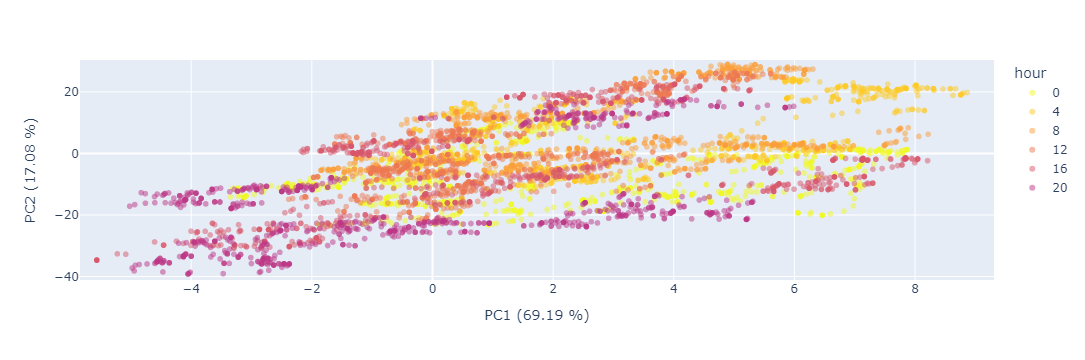

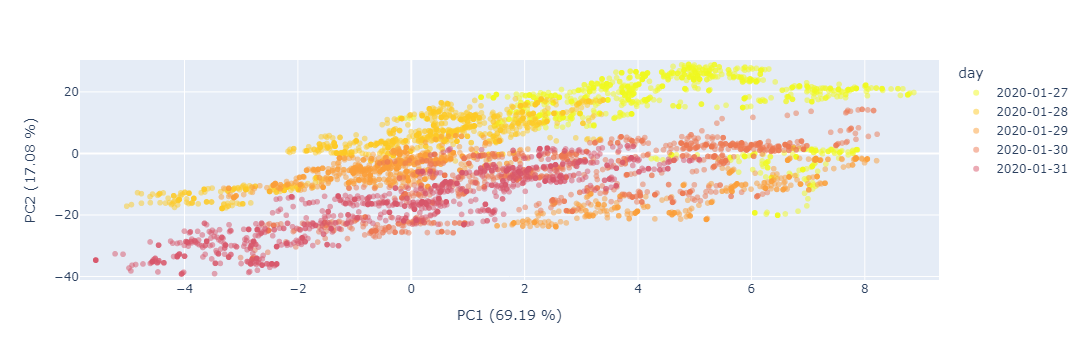

In [6]:
if SPARK:
    # adapter from Pyspark to Pandas, just for visuals
    no_occupants_filtered_df = no_occupants_filtered_df.select("*").toPandas()
    pca_no_occupants_ = pca_no_occupants.withColumn('pcaFeatures', vector_to_array('pcaFeatures'))
    pca_no_occupants_ = np.array(pca_no_occupants.select("*").toPandas()['pcaFeatures'].tolist())

if PANDAS:
    pca_no_occupants_ = pca_no_occupants
    
# Query the DataFrame for the date range
start_date = np.datetime64('2020-01-27')
end_date = np.datetime64('2020-02-01')
no_occupants_filtered_df['timestamp'] = pd.to_datetime(no_occupants_filtered_df['timestamp']).dt.tz_localize(None)
visual_days = ((no_occupants_filtered_df['timestamp'] >= start_date) & (no_occupants_filtered_df['timestamp'] <= end_date) & 
               ((no_occupants_filtered_df['timestamp'].dt.hour == 0) | (no_occupants_filtered_df['timestamp'].dt.hour == 4) | 
                (no_occupants_filtered_df['timestamp'].dt.hour == 8) | (no_occupants_filtered_df['timestamp'].dt.hour == 12) | 
                (no_occupants_filtered_df['timestamp'].dt.hour == 16) | (no_occupants_filtered_df['timestamp'].dt.hour == 20)))

visual_data = pca_no_occupants_[visual_days]
visual_data_days_df = pd.DataFrame({'PC1':visual_data[:,1], 'PC2':visual_data[:,0], 'day':pd.to_datetime(no_occupants_filtered_df['timestamp'][visual_days]).dt.date})
visual_data_hours_df = pd.DataFrame({'PC1':visual_data[:,1], 'PC2':visual_data[:,0], 'hour':pd.to_datetime(no_occupants_filtered_df['timestamp'][visual_days]).dt.hour.astype('str')})


## Plot no occupant data before environmental correction by hour
x_min, x_max = visual_data_hours_df['PC1'].min()*1.05, visual_data_hours_df['PC1'].max()*1.05
y_min, y_max = visual_data_hours_df['PC2'].min()*1.05, visual_data_hours_df['PC2'].max()*1.05

fig = px.scatter(visual_data_hours_df, x='PC1', y='PC2', color='hour', opacity=0.5, color_discrete_sequence= px.colors.sequential.Plasma_r)
fig.update_traces(marker=dict(colorscale='Viridis'), selector=dict(type='scatter'))
fig.update_layout(
    xaxis_title="PC1 ({:.2f} %)".format(var_proj[0]*100),
    yaxis_title="PC2 ({:.2f} %)".format(var_proj[1]*100),
    xaxis_range=[x_min, x_max],
    yaxis_range=[y_min, y_max]  
)
fig.show()


## Plot no occupant data before environmental correction by day
fig = px.scatter(visual_data_days_df, x='PC1', y='PC2', color='day', opacity=0.5, color_discrete_sequence= px.colors.sequential.Plasma_r)
fig.update_traces(marker=dict(colorscale='Viridis'), selector=dict(type='scatter'))
fig.update_layout(
    xaxis_title="PC1 ({:.2f} %)".format(var_proj[0]*100),
    yaxis_title="PC2 ({:.2f} %)".format(var_proj[1]*100),
    xaxis_range=[x_min, x_max],
    yaxis_range=[y_min, y_max]  
)
fig.show()

PCA space representation of the data set without human activity before environmental correction. Samples colored by time of the day (top) and colored by day (bottom). Due to environmental factors, the samples are ordered by time of the day or by the day of acquisition.

### No occupant data - after enviromental correction

We build another PCA just to visually investigate the effect on no occupant data.

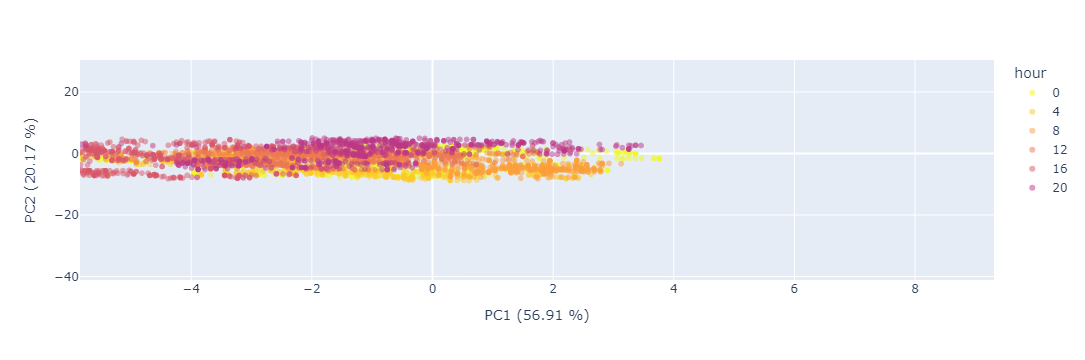

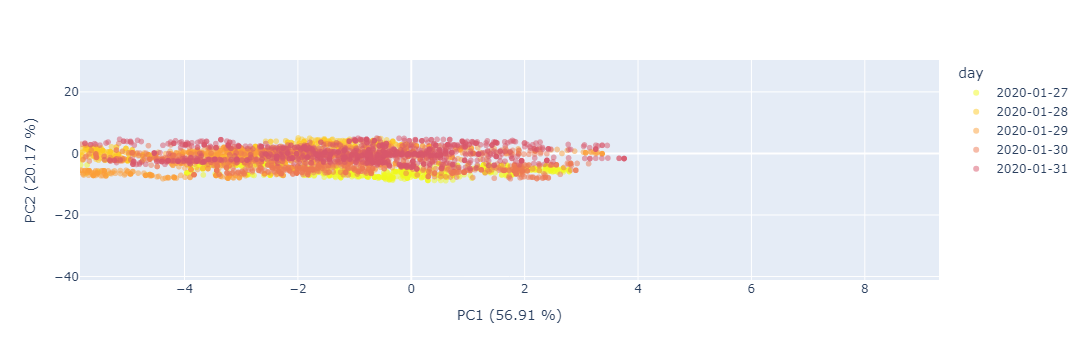

In [7]:
n_new_components = 2

if PANDAS:
    # new PCA on same dataset without 
    #transformed_data_without_first_component = pca_no_occupants.copy()
    # new PCA on filtered data
    transformed_data_without_first_component = pca_no_occupants[visual_days].copy()
    
    # removing first component of PCA by setting it to zero
    transformed_data_without_first_component[:,0] = 0

    # reprojecting data in original space without first component
    pca_after_corr = sklearn.decomposition.PCA(n_components=n_new_components)
    inv_transf = pca.inverse_transform(transformed_data_without_first_component)

    visual_data = pca_after_corr.fit_transform(inv_transf)
    var_new_proj = pca_after_corr.explained_variance_ratio_

if SPARK:
    # unzipping vectors inside the single column to multiple columns
    pca_no_occupants_unzipped = pca_no_occupants.select(['pcaFeatures']).withColumn("feature", vector_to_array("pcaFeatures")).select([col("feature")[i] for i in range(n_components)])
    
    # zero-ing the first component of the pca, to remove it from re-projection in the original space
    pca_no_occupants_unzipped = pca_no_occupants_unzipped.withColumn('feature[0]',lit(0))
    
    # re-zipping features into single column
    assembler_invert = VectorAssembler(inputCols = pca_no_occupants_unzipped.columns, outputCol = 'pcaFeatures')
    pca_no_occupants_zipped = assembler_invert.transform(pca_no_occupants_unzipped).select('pcaFeatures')
    
    # re-projecting to the original space
    inv_transf = pd.DataFrame(pca.inverse_transform(pca_no_occupants_zipped))

    # Define new PCA model
    pca_after_corr = PCAWrapper(k=n_new_components, inputCol="pcaFeatures", outputCol="pcaFeatures2", centering_data=True)
    
    # Fit the model to the data
    pca_after_corr = pca_after_corr.fit(pca_no_occupants_zipped)

    # Transform the data
    visual_data = pca_after_corr.transform(pca_no_occupants_zipped).select("pcaFeatures2").toPandas()
    visual_data = np.array(visual_data['pcaFeatures2'].tolist())

    var_new_proj = pca_after_corr.explainedVariance
    

visual_data =visual_data[visual_days]

visual_data_day_df = pd.DataFrame({'PC1':visual_data[:,1], 'PC2':visual_data[:,0], 'day':pd.to_datetime(no_occupants_filtered_df['timestamp'][visual_days]).dt.date})
visual_data_hours_df = pd.DataFrame({'PC1':visual_data[:,1], 'PC2':visual_data[:,0], 'hour':pd.to_datetime(no_occupants_filtered_df['timestamp'][visual_days]).dt.hour.astype('str')})

## Plot no occupant data after environmental correction by hour
fig = px.scatter(visual_data_hours_df, x='PC1', y='PC2', color='hour', opacity=0.5, color_discrete_sequence= px.colors.sequential.Plasma_r)
fig.update_traces(marker=dict(colorscale='Viridis'), selector=dict(type='scatter'))
fig.update_layout(
    xaxis_title="PC1 ({:.2f} %)".format(var_new_proj[0]*100),
    yaxis_title="PC2 ({:.2f} %)".format(var_new_proj[1]*100),
    xaxis_range=[x_min, x_max],
    yaxis_range=[y_min, y_max] 
)
fig.show()

## Plot no occupant data after environmental correction by day
fig = px.scatter(visual_data_day_df, x='PC1', y='PC2', color='day', opacity=0.5, color_discrete_sequence= px.colors.sequential.Plasma_r)
fig.update_traces(marker=dict(colorscale='Viridis'), selector=dict(type='scatter'))
fig.update_layout(
    xaxis_title="PC1 ({:.2f} %)".format(var_new_proj[0]*100),
    yaxis_title="PC2 ({:.2f} %)".format(var_new_proj[1]*100),
    xaxis_range=[x_min, x_max],
    yaxis_range=[y_min, y_max]   
)
fig.show()

PCA space representation of the data set without human activity after environmental correction. Samples colored by time of the day (top) and colored by day (bottom). The samples overlap each other, with a reduced structure on the environmental factors.

### Occupant data - after environmental correction

We project the data with occupants in the vector space obtained by PCA on no occupant data, and we remove the first component supposing that it corresponds to noise.

In [8]:
if SPARK:
    # grouping features in an unique input column
    assembled_df_occupants = assembler.transform(occupants_filtered_df).select('features')
    
    # projecting features of occupant data into space generated by no occupant data
    pca_occupants = pca.transform(assembled_df_occupants).select("pcaFeatures")
    
    # unzipping vectors inside the single column to multiple columns
    pca_occupants_unzipped = pca_occupants.select(['pcaFeatures']).withColumn("feature", vector_to_array("pcaFeatures")).select([col("feature")[i] for i in range(n_components)])
    
    # zero-ing the first component of the pca, to remove it from re-projection in the original space
    pca_occupants_unzipped = pca_occupants_unzipped.withColumn('feature[0]',lit(0))

    # zipping vectors to a single colum
    pca_occupants_zipped = assembler_invert.transform(pca_occupants_unzipped).select('pcaFeatures')

    # reproject it to original space
    inv_transf_occupants = spark.createDataFrame(pca.inverse_transform(pca_occupants_zipped), schema=cols_to_process)

    inv_transf_occupants.show()

24/05/07 15:16:43 WARN TaskSetManager: Stage 73 contains a task of very large size (17066 KiB). The maximum recommended task size is 1000 KiB.


+------------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------------+-----------------+
|       temperature|          humidity|    CO2CosIRValue|    CO2MG811Value|              MOX1|             MOX2|             MOX3|             MOX4|          COValue|
+------------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------------+-----------------+
|25.002374414471568| 55.49982308369152|  99.849061461227|561.7469994344168|481.60707801212226|783.2003118303214|675.0795648033721|615.1185358878172|95.12831246766574|
| 24.97822880152319| 55.51347056010166|99.86201714281817|561.6182153888012|481.88667366988284|783.0731016127517|675.0954977593676|615.1269577702874|95.29835124062694|
|24.988806515595396|55.503822316794746|99.89252377446255|561.6245488571992|481.81195480994495|782.9837870348144|675.0301759070272| 615.025819345477|94.86385136021491

24/05/07 15:16:47 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 73 (TID 65): Attempting to kill Python Worker
